# Multiclass Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
)

ใน notebook ที่ผ่านมา เราแสดงการทำ binary classification ไปแล้วหลายครั้ง คราวนี้เราจะสาธิตตัวอย่างการทำ multiclass classification

Dataset ที่จะใช้ต่อไปนี้ มีทั้งหมด 37 column โดย 36 column แรกเป็นค่าของแต่ละ pixel ของภาพขนาด 3x3 ทั้งหมด 4 band (red, green, blue และ near-infrared ตามลำดับ) ส่วน column สุดท้ายเป็นชนิดของดินที่ถูกถ่ายเป็น pixel ตรงกลางภาพ สิ่งที่เราต้องทำคือ สร้าง classifier ระบุชนิดของดินที่ถูกถ่ายเป็น pixel ตรงกลางภาพ

<b>Download data</b>

In [2]:
# Thanks Cedric John for data
# The data are already cleaned and have no duplicated/missing values.
# Import data
data = pd.read_csv('../data/sat.trn', sep=' ', header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,grey soil
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,grey soil
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,grey soil
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,grey soil
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,grey soil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,56,64,108,96,64,71,108,96,68,75,...,92,66,83,108,96,66,87,104,89,soil with vegetation stubble
4431,64,71,108,96,68,75,108,96,71,87,...,96,66,87,104,89,63,87,104,89,soil with vegetation stubble
4432,68,75,108,96,71,87,108,88,71,91,...,89,63,87,104,89,70,100,104,85,damp grey soil
4433,71,87,108,88,71,91,100,81,76,95,...,89,70,100,104,85,70,91,104,85,damp grey soil


<b>Pre-process data</b>

In [3]:
# Prepare X and y and normalise pixel values
X, y = data.drop(36, axis=1)/255, data[36]
# Encode labels
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<b>Print soil classes</b>

In [4]:
encoder.classes_

array(['cotton crop', 'damp grey soil', 'grey soil', 'red soil',
       'soil with vegetation stubble', 'very damp grey soil'],
      dtype=object)

Now we know that there are 6 soil classes.

<b>Dummy model</b>

In [5]:
# Dummy model

# Predict using a dummy model
dummy = DummyClassifier(strategy="stratified", random_state=42).fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
# Assess the performance of the model
print("Precision:", precision_score(y_test, dummy_pred, average=None))
print("Accuracy:", accuracy_score(y_test, dummy_pred))
print("Recall:", recall_score(y_test, dummy_pred, average=None))
print("F1:", f1_score(y_test, dummy_pred, average=None))

Precision: [0.14184397 0.1171875  0.23928571 0.29090909 0.125      0.27469136]
Accuracy: 0.22764838467317805
Recall: [0.1459854  0.12931034 0.24452555 0.28742515 0.10126582 0.28525641]
F1: [0.14388489 0.12295082 0.24187726 0.28915663 0.11188811 0.27987421]


You can see above that the fourth soil class (index 3) has the best score. We can look at what is returned from `encoder.classes_` to check what the fourth soil class is, but we can also check it using `.inverse_transform` method of our encoder.

In [6]:
# Find the soil class that has the best performance - index 3
encoder.inverse_transform([3])[0]

'red soil'

<b>Confusion matrix</b>

In [7]:
def make_confusion_matrix(y_true, y_pred, encoder, title='Confusion Matrix'):
    """Make a confusion matrix for multiclass classification task."""

    f1 = f1_score(y_true, y_pred, average='macro')  # Compute average F1 score
    labels = encoder.classes_  # Get soil class names
    # Compute classification counts
    classification_counts = confusion_matrix(y_true, y_pred)  # 2D array
    # Compute classification percentages and convert them to a specific format
    classification_percentages = []
    for counts in classification_counts: 
        classification_percentages.append([f'{count}\n({count/counts.sum()*100:.1f}%)' for count in counts])
    # Make a dataframe of the classification counts
    classification_counts = pd.DataFrame(classification_counts, columns=labels, index=labels)
    # Plot
    fig, ax = plt.subplots(figsize=(5, 5))    
    sns.heatmap(classification_counts,
                cmap='coolwarm',
                annot=classification_percentages,
                fmt='',
                square=True,
                cbar=False,
                ax=ax);
    ax.set_xlabel('Predicted Labels', size=14, weight='bold')
    ax.set_ylabel('True Labels', size=14, weight='bold')
    ax.set_title(f'{title}\nF1 Score: {f1:.2f}', size=16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

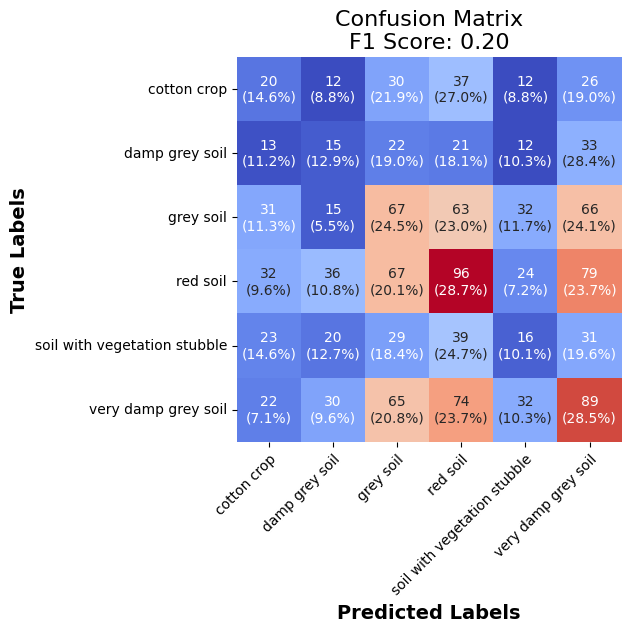

In [8]:
make_confusion_matrix(y_test, dummy_pred, encoder)

<b>Baseline model</b>

Be mindful that a dummy model (simply a random guess) is not the same as a baseline model (i.e., a model that is simple but has a good chance of having predictive power). Linear models are a good way to start in most cases.

To use `sklearn.linear_model.LogisticRegression` for multiclass classification, the `multi_class` parameter is required. It can be either `multi_class="ovr"` or `multi_class="multinomial"`, but the result will be different.

Precision: [0.87919463 0.5        0.80966767 0.93913043 0.90769231 0.67425968]
Accuracy: 0.8106686701728024
Recall: [0.95620438 0.00862069 0.97810219 0.97005988 0.37341772 0.94871795]
F1: [0.91608392 0.01694915 0.88595041 0.95434462 0.52914798 0.78828229]


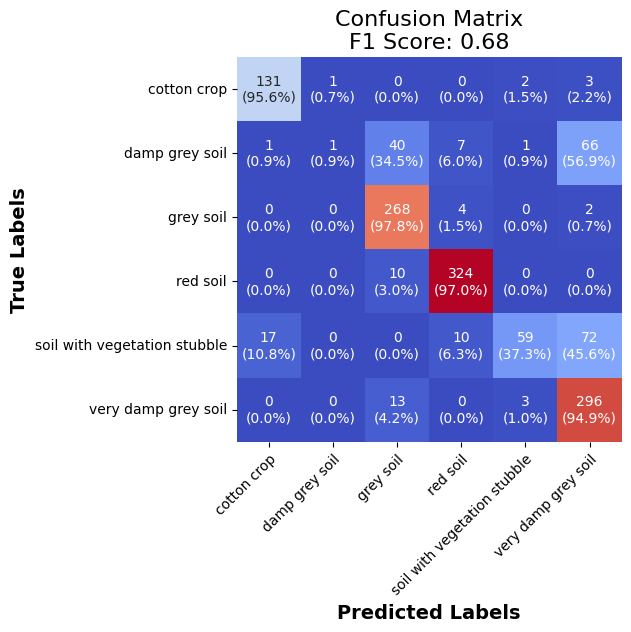

In [9]:
# Logistic regression with multi_class="ovr"

logit_ovr = LogisticRegression(max_iter=5000, multi_class='ovr').fit(X_train, y_train)
y_pred_ovr = logit_ovr.predict(X_test)

precision_ovr = precision_score(y_test, y_pred_ovr, average=None)
accuracy_ovr = accuracy_score(y_test, y_pred_ovr)
recall_ovr = recall_score(y_test, y_pred_ovr, average=None)
f1_ovr = f1_score(y_test, y_pred_ovr, average=None)
print("Precision:", precision_ovr)
print("Accuracy:", accuracy_ovr)
print("Recall:", recall_ovr)
print("F1:", f1_ovr)

make_confusion_matrix(y_test, y_pred_ovr, encoder)

Precision: [0.94573643 0.34782609 0.8381877  0.93768546 0.78571429 0.72235872]
Accuracy: 0.8249436513899324
Recall: [0.89051095 0.06896552 0.94525547 0.94610778 0.62658228 0.94230769]
F1: [0.91729323 0.11510791 0.88850772 0.94187779 0.6971831  0.8178025 ]


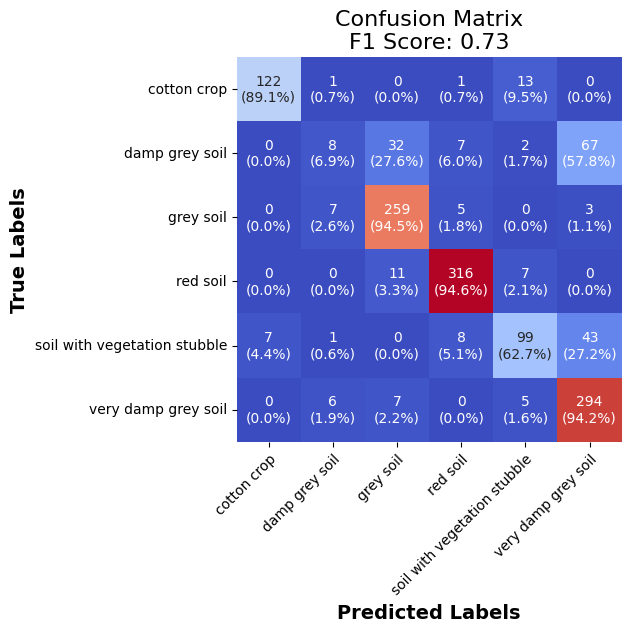

In [10]:
# Logistic regression with multi_class="multinomial"

logit_multi = LogisticRegression(max_iter=5000, multi_class='multinomial').fit(X_train, y_train)
y_pred_multi = logit_multi.predict(X_test)

precision_multi = precision_score(y_test, y_pred_multi, average=None)
accuracy_multi= accuracy_score(y_test, y_pred_multi)
recall_multi = recall_score(y_test, y_pred_multi, average=None)
f1_multi = f1_score(y_test, y_pred_multi, average=None)
print("Precision:", precision_multi)
print("Accuracy:", accuracy_multi)
print("Recall:", recall_multi)
print("F1:", f1_multi)

make_confusion_matrix(y_test, y_pred_multi, encoder)

In [11]:
# Compare the performance between logistic regression with multi_class="ovr"
# and that with multi_class="multinomial"
print(np.mean(precision_ovr - precision_multi))
print(np.mean(recall_ovr - recall_multi))
print(np.mean(accuracy_ovr - accuracy_multi))
print(np.mean(f1_ovr - f1_multi))

0.022072672802120646
-0.030767814390698523
-0.01427498121713
-0.047835647202337794


Therefore, Logistic regression model with `multi_class="multinomial"` performs better.

You can try other models (e.g., KNN) to see if any of them works better than our baseline model (Logistic regression model with `multi_class="multinomial"`). Once you have got the best model, you can use it to predict on unseen data.